<a href="https://colab.research.google.com/github/LoniQin/deep_learning_notebooks/blob/master/English_Spanish_Translation_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# English-Spanish Translation with Transformer

# Configuration

In [1]:
 class Config:
    vocab_size = 16000 # Vocabulary Size
    sequence_length = 20
    batch_size = 512
    validation_split = 0.15
    embed_dim = 256
    latent_dim = 256
    num_heads = 4
    epochs = 30 # Number of Epochs to train
    is_training = False
config = Config()

## Set up the environtment

In [4]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import pathlib
import random
import string
import re
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from sklearn.model_selection import train_test_split
import opendatasets as od
print(f"Tensorflow Version:{tf.__version__}")

Tensorflow Version:2.12.0


## Utilities

In [8]:
def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

## Load data

In [6]:
od.download("https://www.kaggle.com/datasets/lonnieqin/englishspanish-translation-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lonnieqin
Your Kaggle Key: ··········


100%|██████████| 2.72M/2.72M [00:00<00:00, 154MB/s]

In [7]:
od.download("https://www.kaggle.com/datasets/lonnieqin/english-spanish-translation-transformer-model")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lonnieqin
Your Kaggle Key: ··········


100%|██████████| 161M/161M [00:02<00:00, 65.6MB/s]


In [10]:
data = pd.read_csv(f"/content/englishspanish-translation-dataset/data.csv")
data["spanish"] = data["spanish"].apply(lambda item: "[start] " + item + " [end]")
data.head()

,english,spanish
0,Go.,[start] Ve. [end]
1,Go.,[start] Vete. [end]
2,Go.,[start] Vaya. [end]
3,Go.,[start] Váyase. [end]
4,Hi.,[start] Hola. [end]


In [11]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "").replace("]", "")
print(strip_chars)
def spanish_standardize(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]"%re.escape(strip_chars), "")

## Build Vocabularies
english_vectorization = TextVectorization(
    max_tokens=config.vocab_size, 
    output_mode="int", 
    output_sequence_length=config.sequence_length,
)
spanish_vectorization = TextVectorization(
    max_tokens=config.vocab_size,
    output_mode="int",
    output_sequence_length=config.sequence_length + 1,
    standardize=spanish_standardize,
)
english_vectorization.adapt(list(data["english"]))
spanish_vectorization.adapt(list(data["spanish"]))

!"#$%&'()*+,-./:;<=>?@\^_`{|}~¿


In [12]:
def preprocess(english, spanish):
    english = english_vectorization(english)
    spanish = spanish_vectorization(spanish)
    return ({"encoder_inputs": english, "decoder_inputs": spanish[:, :-1]}, spanish[:, 1:])
def make_dataset(df, batch_size, mode):
    dataset = tf.data.Dataset.from_tensor_slices((list(df["english"]), list(df["spanish"])))
    if mode == "train":
       dataset = dataset.shuffle(batch_size * 4) 
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(preprocess)
    dataset = dataset.prefetch(tf.data.AUTOTUNE).cache()
    return dataset

In [13]:
train, valid = train_test_split(data, test_size=config.validation_split, random_state=42)
train.shape, valid.shape

((101119, 2), (17845, 2))

In [14]:
train_ds = make_dataset(train, batch_size=config.batch_size, mode="train")
valid_ds = make_dataset(valid, batch_size=config.batch_size, mode="valid")

In [15]:
for batch in train_ds.take(1):
    print(batch)

({'encoder_inputs': <tf.Tensor: shape=(512, 20), dtype=int64, numpy=
array([[  9, 192, 343, ...,   0,   0,   0],
       [156,  41, 113, ...,   0,   0,   0],
       [  3, 223, 556, ...,   0,   0,   0],
       ...,
       [ 73,   5,  36, ...,   0,   0,   0],
       [ 34,  33,   7, ...,   0,   0,   0],
       [  6,  14, 814, ...,   0,   0,   0]])>, 'decoder_inputs': <tf.Tensor: shape=(512, 20), dtype=int64, numpy=
array([[   2,  229,  328, ...,    0,    0,    0],
       [   2, 3401,   34, ...,    0,    0,    0],
       [   2,   14, 4485, ...,    0,    0,    0],
       ...,
       [   2,   16,   27, ...,    0,    0,    0],
       [   2,    7,   99, ...,    0,    0,    0],
       [   2,    8,   45, ...,    0,    0,    0]])>}, <tf.Tensor: shape=(512, 20), dtype=int64, numpy=
array([[ 229,  328,   53, ...,    0,    0,    0],
       [3401,   34, 1284, ...,    0,    0,    0],
       [  14, 4485,   10, ...,    0,    0,    0],
       ...,
       [  16,   27,    7, ...,    0,    0,    0],
       [

## Modeling

In [17]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, 
            output_dim=embed_dim,
            mask_zero=True
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, 
            output_dim=embed_dim,
            mask_zero=True
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential([
            layers.Dense(latent_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True
        
    def call(self, inputs, encoder_outputs, mask = None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask != None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs, 
            value=inputs, 
            key=inputs, 
            attention_mask=causal_mask
        )
        
        out_1 = self.layernorm_1(inputs + attention_output_1)
        
        attention_output_2 = self.attention_2(
            query=out_1, 
            value=encoder_outputs, 
            key=encoder_outputs, 
            attention_mask=padding_mask
        )
        
        out_2 = self.layernorm_2(out_1 + attention_output_2)
        
        proj_output = self.dense_proj(out_2)
        out = self.layernorm_3(out_2 + proj_output)

        return out
    
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)


def edit_distance(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.argmax(y_pred, axis=-1, output_type=y_true.dtype)
    y_true_tensor =  tf.sparse.from_dense(
        y_true
    )
    y_pred_tensor = tf.sparse.from_dense(
        y_pred
    )
    metric = 1 - tf.edit_distance(y_true_tensor, y_pred_tensor, normalize=True)
    return metric

def get_transformer(config):
    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
    x = PositionalEmbedding(config.sequence_length, config.vocab_size, config.embed_dim)(encoder_inputs)
    encoder_outputs = TransformerEncoder(config.embed_dim, config.num_heads, config.latent_dim)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)

    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(shape=(None, config.embed_dim), name="decoder_state_inputs")
    x = PositionalEmbedding(config.sequence_length, config.vocab_size, config.embed_dim)(decoder_inputs)
    x = TransformerDecoder(config.embed_dim, config.latent_dim, config.num_heads)(x, encoded_seq_inputs)
    x = layers.Dropout(0.5)(x)
    decoder_outputs = layers.Dense(config.vocab_size, activation="softmax")(x)
    decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    transformer = keras.Model(
        [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
    )
    transformer.compile(
        "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return transformer

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   4101120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   1184512     ['positional_embedding[

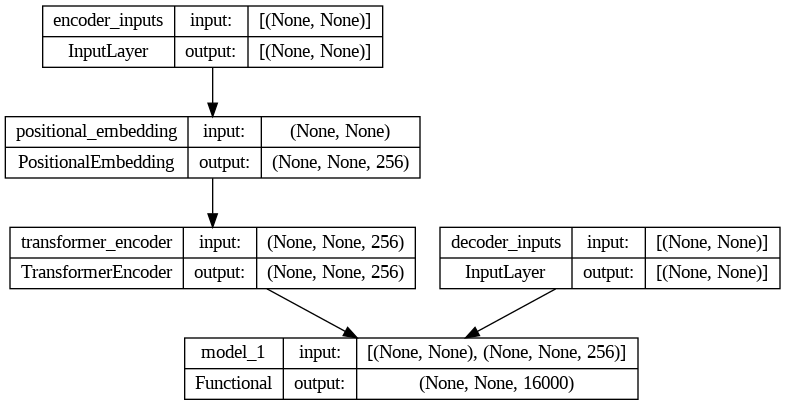

In [18]:
transformer = get_transformer(config)
transformer.summary()
keras.utils.plot_model(transformer, show_shapes=True)

## Training or loading model

In [19]:
if config.is_training:
    checkpoints = tf.keras.callbacks.ModelCheckpoint(
        "model.tf", 
        monitor="val_accuracy", 
        mode="max", 
        save_best_only=True
    )
    early_stop = tf.keras.callbacks.EarlyStopping(
        patience=10,
        monitor="val_loss",
        mode="min",
        restore_best_weights=True
    )
    transformer.fit(train_ds, epochs=config.epochs, validation_data=valid_ds, callbacks=[checkpoints, early_stop])
    transformer.load_weights("model.tf")
else:
    transformer.load_weights("/content/english-spanish-translation-transformer-model/model.tf")

## Evaluating model

In [20]:
transformer.evaluate(valid_ds)

35/35 [==============================] - 273s 8s/step - loss: 1.6179 - accuracy: 0.7233


[1.6178680658340454, 0.7233039140701294]

## Translation

In [21]:
spanish_vocab = spanish_vectorization.get_vocabulary()
spanish_index_lookup = dict(zip(range(len(spanish_vocab)), spanish_vocab))
def remove_start_and_end_token(sentence):
    return sentence.replace("[start] ", "").replace(" [end]", "")
def decode_sequence(transformer, input_sentence):
    tokenized_input_sentence = english_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(config.sequence_length):
        tokenized_target_sentence = spanish_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spanish_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return remove_start_and_end_token(decoded_sentence)

In [22]:
decode_sequence(transformer, "hi")

'hola'

In [23]:
for i in np.random.choice(len(data), 100):
    item = data.iloc[i]
    translated = decode_sequence(transformer, item["english"])
    print("English:", remove_start_and_end_token(item["english"]))
    print("Spanish:", remove_start_and_end_token(item["spanish"]))
    print("Translated:", translated)

English: I'm not sure I want to do this.
Spanish: No estoy seguro de querer hacerlo.
Translated: no estoy segura de querer hacer esto
English: Did I write that?
Spanish: ¿Yo escribí eso?
Translated: yo escribí eso
English: He won't be home at lunch time.
Spanish: Él no va a estar en casa a la hora de almuerzo.
Translated: Él no estará en casa a almorzar
English: Her brother is married, but he doesn't have children.
Spanish: Su hermano es casado, pero no tiene hijos.
Translated: su hermano está casado pero no tiene hijos
English: I had an argument with Tom about the use of marijuana.
Spanish: Discutí con Tom sobre el uso de la marihuana.
Translated: discutí con tom sobre el uso de la marihuana
English: I want to see your boss.
Spanish: Quiero ver a su jefe.
Translated: quiero ver a tu jefe
English: When will he go home?
Spanish: ¿Cuándo irá a casa?
Translated: cuándo va a casa
English: Is this the right bus for Boston?
Spanish: ¿Este es el autobús hacia Boston?
Translated: es este el au